# Homework 08
### IANNWTF 20/21
group 08: Johanna Linkemeyer, Marisa Wodrich





In this homework we implemented a **generative adversarial network** for the Fashion MNIST dataset.


In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import time
from tensorflow.keras import Model
import tensorflow.keras.layers as layers
import tensorflow.keras.backend as K

## **Data set**
We worked with the Fashion MNIST data set. 
* 60000 train images
* 10000 test images
* size 28 x 28 x 1 
* 10 different categories

For this task we mainly used the train images. We also did not use the labels, are they are not needed for training neither the discriminator nor the Generator of our implemented GAN.
The test_images are not entirely used, but only a small random subpart of them will be used in each testing step.

In [2]:
# Load fashion MNIST dataset 
(train_images, _), (test_images, _) = tf.keras.datasets.fashion_mnist.load_data()

**Taking a look at the data**

Print the shape and value range and print some examples to understand the data set.

In [3]:
# Print info on images
print('Train images - Shape: %s - Value range: %s' % (train_images.shape, [np.min(train_images), np.max(train_images)]))
print('Test images - Shape: %s - Value range: %s' % (test_images.shape, [np.min(test_images), np.max(test_images)]))

Train images - Shape: (60000, 28, 28) - Value range: [0, 255]
Test images - Shape: (10000, 28, 28) - Value range: [0, 255]


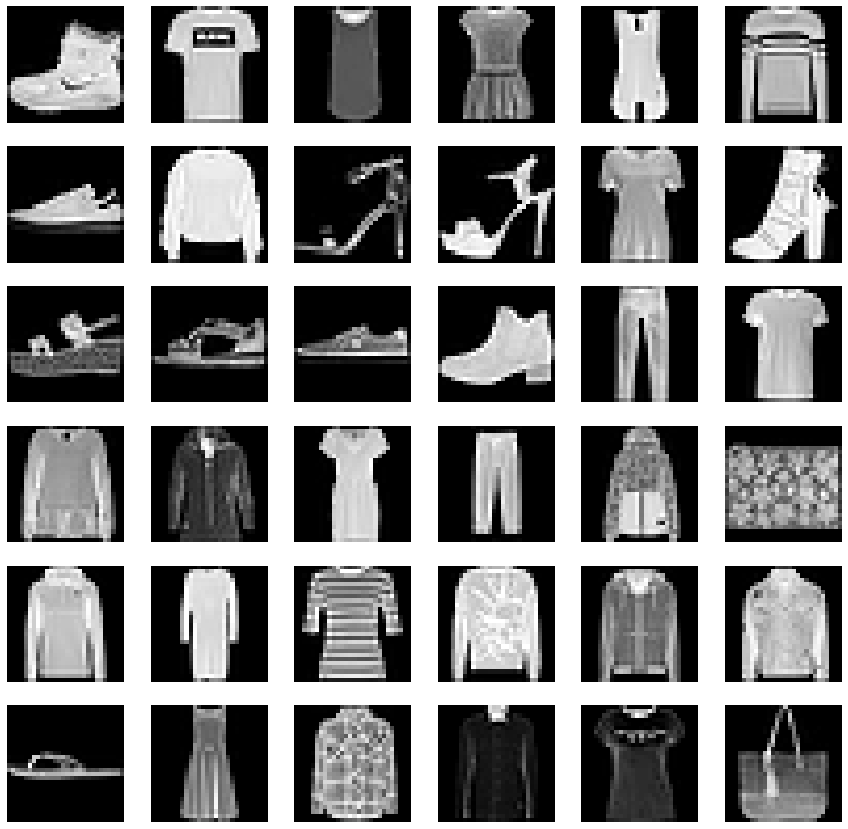

In [4]:
# print some example images

_, ax = plt.subplots(6, 6, figsize=(15,15))
plt.gray() # plot in grayscale

for i, img in enumerate(train_images[:6*6]):
  x, y = int(i / 6), i % 6
  ax[x,y].imshow(img) ; ax[x,y].axis('off')

plt.show()

**Preprocessing steps**

In [5]:
# parameters for our data sets and our models
BATCH_SIZE = 64
LATENTSPACE_SIZE = 100
TEST_SIZE = 10           # how many images are generated at each testing step

In [6]:
# Preprocess training data
train_images = train_images.astype(np.float32)
train_images_prep = tf.expand_dims(train_images, -1)
train_images_prep = tf.data.Dataset.from_tensor_slices(train_images_prep)

# Normalize training images (range [-1,1])
train_images_prep = train_images_prep.map(lambda x: (x/255)*2 - 1)

# Batching and shuffling
train_imgs = train_images_prep.shuffle(buffer_size=10000)
train_imgs = train_imgs.batch(BATCH_SIZE, drop_remainder=True)

In [7]:
# Print info on training set after passing all images through 
# the preprocessing pipeline
print(train_imgs)

<BatchDataset shapes: (64, 28, 28, 1), types: tf.float32>


**Test dataset**

In [8]:
# create test data set

def make_test_data():

  idx = np.random.randint(0,10000-TEST_SIZE)

  # Preprocess a small amount of test images 
  test_images_prep = test_images[idx:idx+TEST_SIZE]
  test_images_prep = tf.expand_dims(test_images, -1)
  test_images_prep = tf.data.Dataset.from_tensor_slices(test_images_prep)

  # Normalize test images (range [-1,1])
  test_images_prep = test_images_prep.map(lambda x: (x/255)*2 - 1)

  # Batching and shuffling (we will use one random batch each time during testing)
  test_imgs = test_images_prep.shuffle(buffer_size=10000)
  test_imgs = test_imgs.batch(TEST_SIZE, drop_remainder=True)

  return test_imgs

In [9]:
# Test the functionality of our test dataset creator
print(make_test_data())

<BatchDataset shapes: (10, 28, 28, 1), types: tf.float32>


**Test vectors**

We create some random latent vectors before training. At each test step, we feed them into the generator and plot the resulting images to evaluate training.

In [10]:
test_vectors = tf.random.normal([TEST_SIZE, LATENTSPACE_SIZE])

## **Model**

We implemented a generative adversarial network. We therefore have: 

* a **Discriminator**: takes in images, returns probabilities in the range from 0-1 that images were fake (0) / real (1)
* a **Generator**: takes in a random vector from the latent space and produces generated image

Both networks try to optimize their task and therefore kind of work against each other.

For the design of the model we used the following sources: 
* https://towardsdatascience.com/gan-by-example-using-keras-on-tensorflow-backend-1a6d515a60d0
* https://www.tensorflow.org/tutorials/generative/dcgan

In [11]:
# activation functions
SIGMOID = tf.nn.sigmoid
TANH = tf.nn.tanh

#### **Discriminator**

In [83]:
class Discriminator(Model):

  def __init__(self, wasserstein=False):
    """
    A Discriminator consists out of several convolutional layers followed by 
    leaky relu and a dropout layer. If initialized as a Wasserstein 
    discriminator by passing the flag wasserstein=True, weight clipping to the 
    range -0.01 to 0.01 is performed.
    In the end, the discriminator will return a value representing whether an 
    image was fake or real.
    """
    super(Discriminator, self).__init__()

    if wasserstein:
      # Apply weight clipping (set kernel + bias constraint with min_max_norm)
      self.conv_1 = layers.Conv2D(filters=16, 
                                  kernel_size=5, 
                                  strides=2, 
                                  input_shape=[28,28,1], 
                                  padding='same', 
                                  activation=None, 
                                  kernel_constraint=tf.keras.constraints.min_max_norm(min_value=-0.01, max_value=0.01),
                                  bias_constraint=tf.keras.constraints.min_max_norm(min_value=-0.01, max_value=0.01))
    else:
      self.conv_1 = layers.Conv2D(filters=16, 
                                  kernel_size=5, 
                                  strides=2, 
                                  input_shape=[28,28,1], 
                                  padding='same', 
                                  activation=None)
    self.leaky_relu_1 = layers.LeakyReLU()
    self.dropout_1 = layers.Dropout(0.3)

    if wasserstein:
      self.conv_2 = layers.Conv2D(filters=32, 
                                  kernel_size=5, 
                                  strides=2, 
                                  padding='same', 
                                  activation=None,
                                  kernel_constraint=tf.keras.constraints.min_max_norm(min_value=-0.01, max_value=0.01),
                                  bias_constraint=tf.keras.constraints.min_max_norm(min_value=-0.01, max_value=0.01))
    else:
      self.conv_2 = layers.Conv2D(filters=32, 
                                  kernel_size=5, 
                                  strides=2, 
                                  padding='same', 
                                  activation=None)
    self.leaky_relu_2 = layers.LeakyReLU()
    self.dropout_2 = layers.Dropout(0.3)

    self.flatten = layers.Flatten()

    if wasserstein:
      self.out = layers.Dense(1, activation=None) # linear activation for Wasserstein
    else:
      self.out = layers.Dense(1, SIGMOID)

  
  def call(self, x, is_training=True):

    x = self.conv_1(x)
    x = self.leaky_relu_1(x)
    x = self.dropout_1(x, is_training)

    x = self.conv_2(x)
    x = self.leaky_relu_2(x)
    x = self.dropout_2(x, is_training)
    
    x = self.flatten(x)
    x = self.out(x)
    
    return x


**Test discriminator functionality**

In [55]:
# Create batch of one black image of size 28x28x1
inp = tf.zeros((1,28,28,1))

# Initialize and test discriminator
discriminator_test = Discriminator()
result = discriminator_test(inp)

# Print information on output and model summary
print(result.shape)
discriminator_test.summary()

(1, 1)
Model: "discriminator_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            multiple                  416       
_________________________________________________________________
leaky_re_lu_6 (LeakyReLU)    multiple                  0         
_________________________________________________________________
dropout_3 (Dropout)          multiple                  0         
_________________________________________________________________
conv2d_5 (Conv2D)            multiple                  12832     
_________________________________________________________________
leaky_re_lu_7 (LeakyReLU)    multiple                  0         
_________________________________________________________________
dropout_4 (Dropout)          multiple                  0         
_________________________________________________________________
conv2d_6 (Conv2D)            multiple       

**Test Wasserstein discriminator functionality**

In [56]:
# Test on the same input as above, initialize discriminator as 
# Wasserstein version
w_discriminator_test = Discriminator(wasserstein=True)
w_result = w_discriminator_test(inp)

# Print information on output and model summary
print(w_result.shape)
w_discriminator_test.summary()

(1, 1)
Model: "discriminator_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_7 (Conv2D)            multiple                  416       
_________________________________________________________________
leaky_re_lu_9 (LeakyReLU)    multiple                  0         
_________________________________________________________________
dropout_6 (Dropout)          multiple                  0         
_________________________________________________________________
conv2d_8 (Conv2D)            multiple                  12832     
_________________________________________________________________
leaky_re_lu_10 (LeakyReLU)   multiple                  0         
_________________________________________________________________
dropout_7 (Dropout)          multiple                  0         
_________________________________________________________________
conv2d_9 (Conv2D)            multiple       

#### **Generator**

In [89]:
class Generator(Model):

  def __init__(self):
    """
    A Generator takes in a one-dimensional vector. 
    It reshapes it and applies several transposed convolutions to 
    return an image in the end.
    """
    super(Generator, self).__init__()

    self.dense = layers.Dense(7*7*128, input_shape=(LATENTSPACE_SIZE,), use_bias=False, activation=None)
    self.leaky_relu_0 = layers.LeakyReLU()
    self.reshape = layers.Reshape((7,7,128))

    self.convT_1 = layers.Conv2DTranspose(filters=64, kernel_size=4, strides=1, padding='same', activation=None, use_bias=False)
    self.batch_norm_1 = layers.BatchNormalization()
    self.leaky_relu_1 = layers.LeakyReLU()

    self.convT_2 = layers.Conv2DTranspose(filters=32, kernel_size=4, strides=2, padding='same', activation=None, use_bias=False)
    self.batch_norm_2 = layers.BatchNormalization()
    self.leaky_relu_2 = layers.LeakyReLU()

    self.convT_3 = layers.Conv2DTranspose(filters=1, kernel_size=4, strides=2, padding='same', activation=TANH, use_bias=False)


  def call(self, x, is_training=True):

    x = self.dense(x)
    x = self.leaky_relu_0(x)
    x = self.reshape(x)

    x = self.convT_1(x)
    x = self.batch_norm_1(x, is_training)
    x = self.leaky_relu_1(x)

    x = self.convT_2(x)
    x = self.batch_norm_2(x)
    x = self.leaky_relu_2(x)

    x = self.convT_3(x)

    return x

**Test generator functionality**

In [90]:
# Create random vector (from latent space)
inp = tf.random.normal([1,LATENTSPACE_SIZE])

# Initialize generator
generator_test = Generator()
result = generator_test(inp, training=False)

# Print test information
print(result.shape)
generator_test.summary()

(1, 28, 28, 1)
Model: "generator_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_2 (Dense)              multiple                  627200    
_________________________________________________________________
leaky_re_lu_5 (LeakyReLU)    multiple                  0         
_________________________________________________________________
reshape_1 (Reshape)          multiple                  0         
_________________________________________________________________
conv2d_transpose_3 (Conv2DTr multiple                  131072    
_________________________________________________________________
batch_normalization_2 (Batch multiple                  256       
_________________________________________________________________
leaky_re_lu_6 (LeakyReLU)    multiple                  0         
_________________________________________________________________
conv2d_transpose_4 (Conv2DTr multiple   

**Taking a look at the performance of the generator right after instantiation**

Value range in image:  -0.6589155 0.6955547


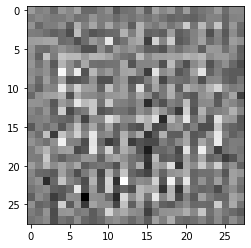

In [79]:
plt.imshow(result[0,:,:,0], cmap='gray')

print('Value range in image: ', np.min(result[0,:,:,0]), np.max(result[0,:,:,0]))

##Training

**Loss for normal GAN**


In [18]:
# we use binary cross entropy loss for both the generator and discriminator
BCE = tf.keras.losses.BinaryCrossentropy(from_logits=True)

def discriminator_loss(output_real_image, output_fake_image):
  """
  The discriminator loss is the sum of the loss of fake images and the loss 
  of real images.
  Correct labels for real and fake images are constructed using zeros_like 
  (for fake images) and ones_like (for real images).
  """
  loss_real = BCE(tf.ones_like(output_real_image), output_real_image)
  loss_fake = BCE(tf.zeros_like(output_fake_image), output_fake_image)

  return loss_real + loss_fake


def generator_loss(output_fake_image):
  """
  The generator loss is the loss of the fake images it created.
  """
  loss = BCE(tf.ones_like(output_fake_image), output_fake_image)

  return loss

**Loss for Wasserstein GAN**

In [19]:
def w_discriminator_loss(output_real_image, output_fake_image):
  """
  Wasserstein loss for the discriminator: Sum of losses for real and fake 
  images which are just the mean for all discriminator outputs of the respective 
  group (negative mean for the real images).
  """
  loss_real = - tf.reduce_mean(output_real_image)
  loss_fake = tf.reduce_mean(output_fake_image)

  return loss_real + loss_fake

def w_generator_loss(output_fake_image):
  """
  Wasserstein loss for the generator is the mean of the output multiplied by -1.
  """

  loss_fake = - tf.reduce_mean(output_fake_image)

  return loss_fake

**Train step and Test step**

define training step function and testing step function

In [20]:
def train_step(generator, discriminator, input, g_loss, d_loss, optimizer_generator, optimizer_discriminator):
  """
  Performs one training step
  generator:                    current generator
  discriminator:                current discriminator
  input:                        the input image that is fed into the discriminator
  g_loss:                       generator loss function
  d_loss:                       discriminator loss function
  optimizer_generator:          optimizer for the generator
  optimizer_discriminator:      optimizer for the discriminator
  Return:                       mean losses for generator and discriminator
  """

  # Create random vector that is used as input for the generator 
  input_generator =  tf.random.normal([BATCH_SIZE, LATENTSPACE_SIZE])

  with tf.GradientTape() as tape_generator, tf.GradientTape() as tape_disriminator:

    # generate an image with the generator
    fake_image = generator(input_generator)

    # feed both the real and the fake batch into the discriminator
    output_real_image = discriminator(input)
    output_fake_image = discriminator(fake_image)

    # Compute losses
    loss_discriminator = d_loss(output_real_image, output_fake_image)
    loss_generator = g_loss(output_fake_image)

    gradients_discriminator = tape_disriminator.gradient(loss_discriminator, discriminator.trainable_variables)
    gradients_generator = tape_generator.gradient(loss_generator, generator.trainable_variables)

  # Adapt network
  optimizer_discriminator.apply_gradients(zip(gradients_discriminator, discriminator.trainable_variables))
  optimizer_generator.apply_gradients(zip(gradients_generator, generator.trainable_variables))

  return np.mean(loss_discriminator), np.mean(loss_generator)


def test(generator, discriminator, g_loss, d_loss, test_vectors):
  """
  Test model over test data
  generator:          current generator
  discriminator:      current discriminator
  g_loss:             generator loss function
  d_loss:             discriminator loss function
  test_vectors:       latent space vectors to generate images with generator
  """

  generated_images = generator(test_vectors, is_training=False)
  testing_images = make_test_data()

  # plot the generated images
  _, ax = plt.subplots(1, 10, figsize=(25, 5))

  for i in range(10):
    img = ((generated_images[i,:,:,0] + 1) / 2) * 255   # transfer back to range[0,255]
    ax[i].imshow(img, cmap='gray') ; ax[i].axis('off')
  
  plt.show()

  output_fake_image = discriminator(generated_images, is_training=False)

  # Test set contains one batch of real images
  for input in testing_images:
    output_real_image = discriminator(input, is_training=False)
  
  # Calculate the losses for both models with the respective functions
  loss_discriminator = d_loss(output_real_image, output_fake_image)
  loss_generator = g_loss(output_fake_image)

  return loss_discriminator, loss_generator

In [27]:
def train(num_epochs, generator, discriminator, g_loss, d_loss, optimizer_generator, optimizer_discriminator):
  """
  Function to train a network (containing train and test steps).
  num_epochs:               number of epochs to train
  generator:                current generator
  discriminator:            current discriminator
  g_loss:                   loss of generator
  d_loss:                   loss of discriminator
  optimizer_generator:      optimizer used for the generator
  optimizer_discriminator:  optimizer used for the generator
  """
  # To keep track of all losses for visualisation
  train_losses_g_all, train_losses_d_all = [], []

  for epoch in range(num_epochs):

    # Track epoch and time while code runs
    start = time.time()
    print('Epoch: __ ' + str(epoch+1))

    # Training (and checking in with training loss of both discriminator 
    # and generator)
    running_average_loss_discriminator = 0
    running_average_loss_generator = 0

    # Iterate over all training images
    for itr, input in enumerate(train_imgs):
      
      # Perform one training step and update discriminator + generator losses
      train_loss_discriminator, train_loss_generator = train_step(generator, discriminator, input, g_loss, d_loss, optimizer_generator, optimizer_discriminator)

      # save losses for visualisation later
      train_losses_d_all.append(train_loss_discriminator)
      train_losses_g_all.append(train_loss_generator)

      running_average_loss_discriminator = running_average_factor * running_average_loss_discriminator  + (1 - running_average_factor) * train_loss_discriminator
      running_average_loss_generator = running_average_factor * running_average_loss_generator  + (1 - running_average_factor) * train_loss_generator
    
      # Print loss always after the next 100 steps within epoch to keep track 
      # of loss changes during training
      if itr % 100 == 0 and itr > 0:
        print('Iteration #%s - Discriminator loss: %s, Generator loss: %s' % (itr, round(train_loss_discriminator, 4), round(train_loss_generator, 4)))

    train_losses_discriminator.append(running_average_loss_discriminator)
    train_losses_generator.append(running_average_loss_generator)

    # Testing 
    test_loss_discriminator, test_loss_generator = test(generator, discriminator, g_loss, d_loss, test_vectors)
    test_losses_discriminator.append(test_loss_discriminator)
    test_losses_generator.append(test_loss_generator)

    duration = time.time() - start

    # Measure time required for each epoch
    print('... finished after %s seconds ' % round(duration, 2))

  return train_losses_discriminator, test_losses_discriminator, train_losses_generator, test_losses_generator, train_losses_g_all, train_losses_d_all

In [35]:
def plot(train_losses_d, test_losses_d, train_losses_g, test_losses_g, train_losses_g_all, train_losses_d_all):
  # Plot loss of the discriminator
  plt.figure(figsize=(20,5))
  plt.plot(train_losses_d, label="train")
  plt.plot(test_losses_d, label="test")
  plt.legend()
  plt.title("Loss Discriminator")
  plt.show()

  # Plot loss of the generator
  plt.figure(figsize=(20,5))
  plt.plot(train_losses_g, label="train")
  plt.plot(test_losses_g, label="test")
  plt.legend()
  plt.title("Loss Generator")
  plt.show()

  # Compare the losses of generator and discriminator throughout the whole 
  # training process
  plt.figure(figsize=(20,5))
  plt.plot(train_losses_g_all, label="Generator")
  plt.plot(train_losses_d_all, label="Discriminator")
  plt.legend()
  plt.title("Generator Loss vs Discriminator Loss")
  plt.show()


**Setup for training**

For training without the WGAN adjustments we chose:
* a learning rate of 0.00001
* binary crossentropy as the discriminator loss
* optimizer: Adam

In [84]:
K.clear_session()
# Use wasserstein (True) or not (False)
WASSERSTEIN = False

# Hyperparameters for training
num_epochs = 20
learning_rate = 0.00001
running_average_factor = 0.95

# Initialize discriminator and generator
discriminator = Discriminator(wasserstein=WASSERSTEIN)
generator = Generator()

# Adam optimizer
optimizer_discriminator = tf.keras.optimizers.Adam(learning_rate)
optimizer_generator = tf.keras.optimizers.Adam(learning_rate)

# Initialize lists for visualization.
train_losses_discriminator, train_losses_generator = [], []
test_losses_discriminator, test_losses_generator = [], []

**Start training**


Epoch: __ 1
Iteration #100 - Discriminator loss: 1.447, Generator loss: 0.465
Iteration #200 - Discriminator loss: 1.4385, Generator loss: 0.4572
Iteration #300 - Discriminator loss: 1.4365, Generator loss: 0.4494
Iteration #400 - Discriminator loss: 1.4279, Generator loss: 0.4471
Iteration #500 - Discriminator loss: 1.4302, Generator loss: 0.4426
Iteration #600 - Discriminator loss: 1.4504, Generator loss: 0.4353
Iteration #700 - Discriminator loss: 1.4614, Generator loss: 0.4318
Iteration #800 - Discriminator loss: 1.4554, Generator loss: 0.4383
Iteration #900 - Discriminator loss: 1.4481, Generator loss: 0.4485


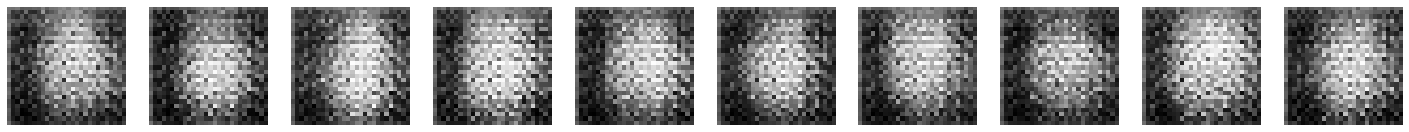

... finished after 30.39 seconds 
Epoch: __ 2
Iteration #100 - Discriminator loss: 1.4416, Generator loss: 0.4557
Iteration #200 - Discriminator loss: 1.4416, Generator loss: 0.4551
Iteration #300 - Discriminator loss: 1.451, Generator loss: 0.4485
Iteration #400 - Discriminator loss: 1.4763, Generator loss: 0.4356
Iteration #500 - Discriminator loss: 1.4701, Generator loss: 0.4397
Iteration #600 - Discriminator loss: 1.4437, Generator loss: 0.4579
Iteration #700 - Discriminator loss: 1.4348, Generator loss: 0.4626
Iteration #800 - Discriminator loss: 1.4593, Generator loss: 0.4427
Iteration #900 - Discriminator loss: 1.4931, Generator loss: 0.4239


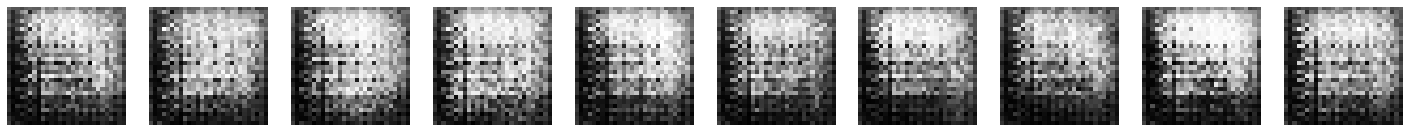

... finished after 30.4 seconds 
Epoch: __ 3
Iteration #100 - Discriminator loss: 1.4719, Generator loss: 0.4392
Iteration #200 - Discriminator loss: 1.4473, Generator loss: 0.4543
Iteration #300 - Discriminator loss: 1.4606, Generator loss: 0.4536
Iteration #400 - Discriminator loss: 1.483, Generator loss: 0.4487
Iteration #500 - Discriminator loss: 1.4725, Generator loss: 0.4545
Iteration #600 - Discriminator loss: 1.4457, Generator loss: 0.4753
Iteration #700 - Discriminator loss: 1.4331, Generator loss: 0.4876
Iteration #800 - Discriminator loss: 1.4324, Generator loss: 0.4851
Iteration #900 - Discriminator loss: 1.4348, Generator loss: 0.4859


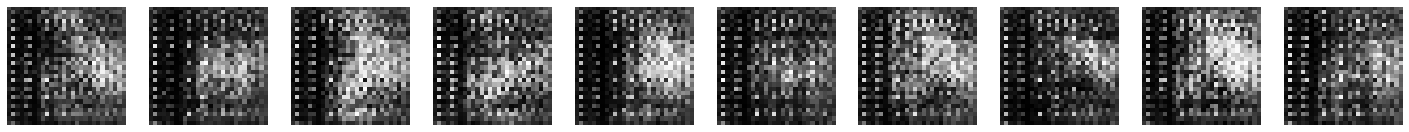

... finished after 30.34 seconds 
Epoch: __ 4
Iteration #100 - Discriminator loss: 1.469, Generator loss: 0.4655
Iteration #200 - Discriminator loss: 1.4764, Generator loss: 0.4645
Iteration #300 - Discriminator loss: 1.4446, Generator loss: 0.4807
Iteration #400 - Discriminator loss: 1.4308, Generator loss: 0.4885
Iteration #500 - Discriminator loss: 1.4575, Generator loss: 0.4772
Iteration #600 - Discriminator loss: 1.4553, Generator loss: 0.4855
Iteration #700 - Discriminator loss: 1.454, Generator loss: 0.4893
Iteration #800 - Discriminator loss: 1.45, Generator loss: 0.4899
Iteration #900 - Discriminator loss: 1.4403, Generator loss: 0.4912


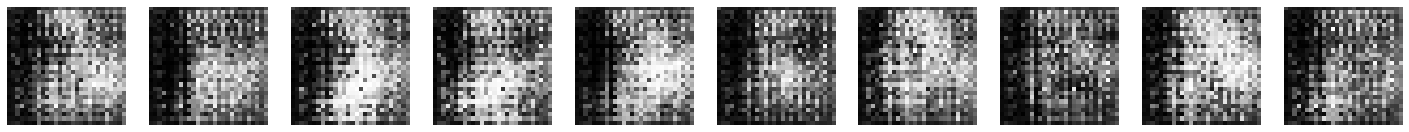

... finished after 30.28 seconds 
Epoch: __ 5
Iteration #100 - Discriminator loss: 1.4249, Generator loss: 0.5008
Iteration #200 - Discriminator loss: 1.4294, Generator loss: 0.5041
Iteration #300 - Discriminator loss: 1.4425, Generator loss: 0.5018
Iteration #400 - Discriminator loss: 1.44, Generator loss: 0.5066
Iteration #500 - Discriminator loss: 1.4285, Generator loss: 0.5172
Iteration #600 - Discriminator loss: 1.4233, Generator loss: 0.531
Iteration #700 - Discriminator loss: 1.4214, Generator loss: 0.5359
Iteration #800 - Discriminator loss: 1.4314, Generator loss: 0.5264
Iteration #900 - Discriminator loss: 1.4305, Generator loss: 0.5268


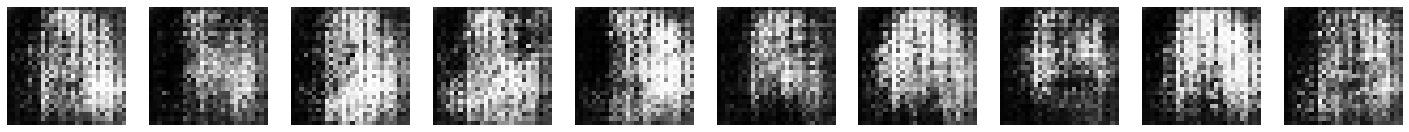

... finished after 30.7 seconds 
Epoch: __ 6
Iteration #100 - Discriminator loss: 1.4086, Generator loss: 0.5502
Iteration #200 - Discriminator loss: 1.4116, Generator loss: 0.5564
Iteration #300 - Discriminator loss: 1.4141, Generator loss: 0.5551
Iteration #400 - Discriminator loss: 1.4161, Generator loss: 0.5609
Iteration #500 - Discriminator loss: 1.4123, Generator loss: 0.5708
Iteration #600 - Discriminator loss: 1.4059, Generator loss: 0.5809
Iteration #700 - Discriminator loss: 1.4042, Generator loss: 0.586
Iteration #800 - Discriminator loss: 1.4135, Generator loss: 0.5862
Iteration #900 - Discriminator loss: 1.4107, Generator loss: 0.5924


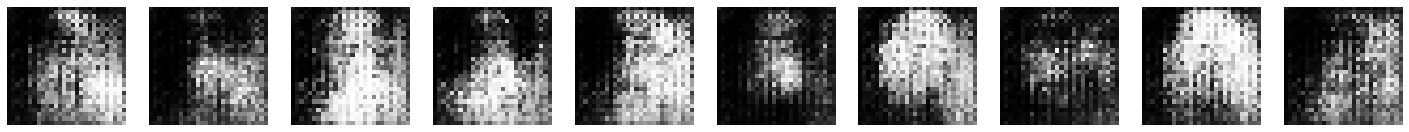

... finished after 30.35 seconds 
Epoch: __ 7
Iteration #100 - Discriminator loss: 1.3991, Generator loss: 0.6076
Iteration #200 - Discriminator loss: 1.3972, Generator loss: 0.6038
Iteration #300 - Discriminator loss: 1.3999, Generator loss: 0.5964
Iteration #400 - Discriminator loss: 1.4069, Generator loss: 0.6007
Iteration #500 - Discriminator loss: 1.3978, Generator loss: 0.6111
Iteration #600 - Discriminator loss: 1.3922, Generator loss: 0.619
Iteration #700 - Discriminator loss: 1.3954, Generator loss: 0.6244
Iteration #800 - Discriminator loss: 1.4007, Generator loss: 0.6221
Iteration #900 - Discriminator loss: 1.4018, Generator loss: 0.6254


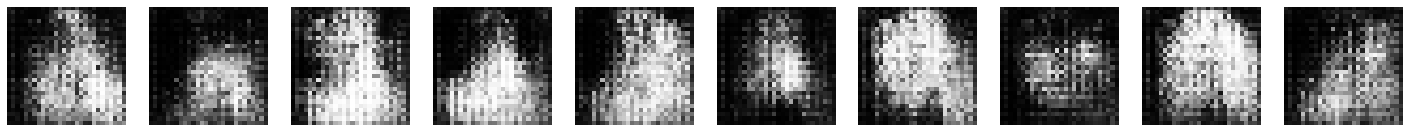

... finished after 30.65 seconds 
Epoch: __ 8
Iteration #100 - Discriminator loss: 1.3946, Generator loss: 0.6322
Iteration #200 - Discriminator loss: 1.3982, Generator loss: 0.6382
Iteration #300 - Discriminator loss: 1.3957, Generator loss: 0.6391
Iteration #400 - Discriminator loss: 1.3975, Generator loss: 0.6367
Iteration #500 - Discriminator loss: 1.3947, Generator loss: 0.6417
Iteration #600 - Discriminator loss: 1.3951, Generator loss: 0.6474
Iteration #700 - Discriminator loss: 1.3901, Generator loss: 0.6524
Iteration #800 - Discriminator loss: 1.3895, Generator loss: 0.6507
Iteration #900 - Discriminator loss: 1.3895, Generator loss: 0.6572


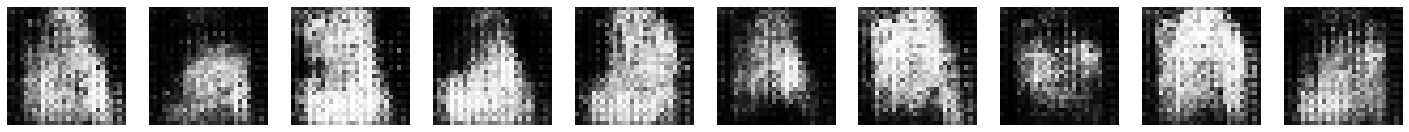

... finished after 30.4 seconds 
Epoch: __ 9
Iteration #100 - Discriminator loss: 1.3915, Generator loss: 0.6597
Iteration #200 - Discriminator loss: 1.3894, Generator loss: 0.6577
Iteration #300 - Discriminator loss: 1.3907, Generator loss: 0.662
Iteration #400 - Discriminator loss: 1.3924, Generator loss: 0.6667
Iteration #500 - Discriminator loss: 1.3914, Generator loss: 0.6652
Iteration #600 - Discriminator loss: 1.3895, Generator loss: 0.6569
Iteration #700 - Discriminator loss: 1.3864, Generator loss: 0.6689
Iteration #800 - Discriminator loss: 1.389, Generator loss: 0.6669
Iteration #900 - Discriminator loss: 1.3882, Generator loss: 0.6616


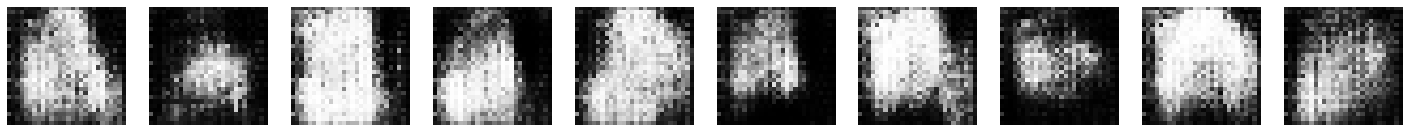

... finished after 30.72 seconds 
Epoch: __ 10
Iteration #100 - Discriminator loss: 1.3892, Generator loss: 0.6661
Iteration #200 - Discriminator loss: 1.3877, Generator loss: 0.6722
Iteration #300 - Discriminator loss: 1.3845, Generator loss: 0.6743
Iteration #400 - Discriminator loss: 1.3875, Generator loss: 0.6716
Iteration #500 - Discriminator loss: 1.3885, Generator loss: 0.6685
Iteration #600 - Discriminator loss: 1.3904, Generator loss: 0.6725
Iteration #700 - Discriminator loss: 1.3904, Generator loss: 0.6744
Iteration #800 - Discriminator loss: 1.3888, Generator loss: 0.6743
Iteration #900 - Discriminator loss: 1.3888, Generator loss: 0.6715


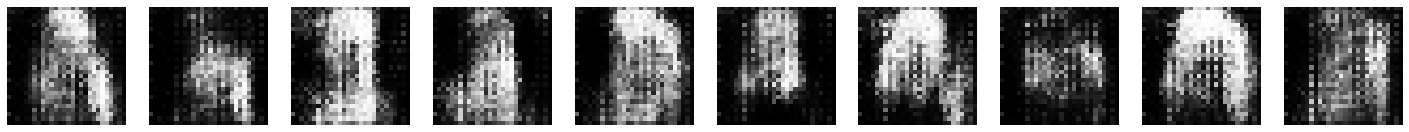

... finished after 30.25 seconds 
Epoch: __ 11
Iteration #100 - Discriminator loss: 1.3864, Generator loss: 0.6785
Iteration #200 - Discriminator loss: 1.3884, Generator loss: 0.6785
Iteration #300 - Discriminator loss: 1.3856, Generator loss: 0.6736
Iteration #400 - Discriminator loss: 1.3871, Generator loss: 0.6792
Iteration #500 - Discriminator loss: 1.3844, Generator loss: 0.6841
Iteration #600 - Discriminator loss: 1.388, Generator loss: 0.6818
Iteration #700 - Discriminator loss: 1.3877, Generator loss: 0.6828
Iteration #800 - Discriminator loss: 1.3859, Generator loss: 0.6799
Iteration #900 - Discriminator loss: 1.3893, Generator loss: 0.6766


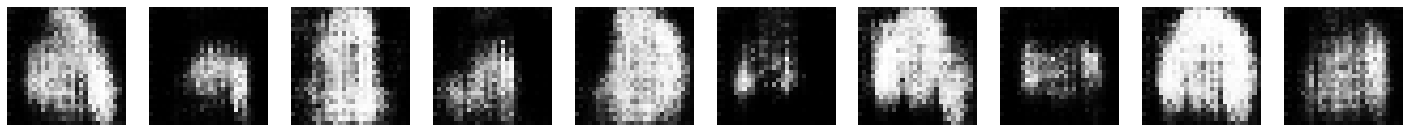

... finished after 30.37 seconds 
Epoch: __ 12
Iteration #100 - Discriminator loss: 1.386, Generator loss: 0.6853
Iteration #200 - Discriminator loss: 1.3863, Generator loss: 0.6862
Iteration #300 - Discriminator loss: 1.3862, Generator loss: 0.6864
Iteration #400 - Discriminator loss: 1.3863, Generator loss: 0.6861
Iteration #500 - Discriminator loss: 1.3873, Generator loss: 0.6853
Iteration #600 - Discriminator loss: 1.3866, Generator loss: 0.685
Iteration #700 - Discriminator loss: 1.3869, Generator loss: 0.684
Iteration #800 - Discriminator loss: 1.385, Generator loss: 0.6829
Iteration #900 - Discriminator loss: 1.3859, Generator loss: 0.6801


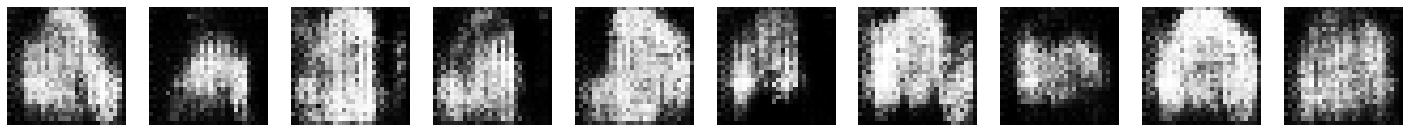

... finished after 30.47 seconds 
Epoch: __ 13
Iteration #100 - Discriminator loss: 1.3891, Generator loss: 0.6754
Iteration #200 - Discriminator loss: 1.3898, Generator loss: 0.6798
Iteration #300 - Discriminator loss: 1.3875, Generator loss: 0.683
Iteration #400 - Discriminator loss: 1.3872, Generator loss: 0.6866
Iteration #500 - Discriminator loss: 1.3864, Generator loss: 0.6893
Iteration #600 - Discriminator loss: 1.3869, Generator loss: 0.6898
Iteration #700 - Discriminator loss: 1.3868, Generator loss: 0.6901
Iteration #800 - Discriminator loss: 1.3869, Generator loss: 0.6902
Iteration #900 - Discriminator loss: 1.3871, Generator loss: 0.6901


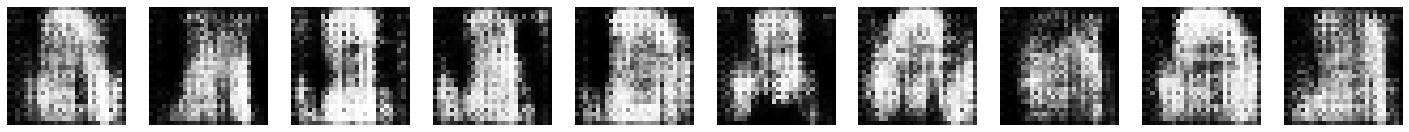

... finished after 30.33 seconds 
Epoch: __ 14
Iteration #100 - Discriminator loss: 1.3857, Generator loss: 0.6891
Iteration #200 - Discriminator loss: 1.3893, Generator loss: 0.6852
Iteration #300 - Discriminator loss: 1.386, Generator loss: 0.6914
Iteration #400 - Discriminator loss: 1.3857, Generator loss: 0.6917
Iteration #500 - Discriminator loss: 1.3848, Generator loss: 0.6913
Iteration #600 - Discriminator loss: 1.3848, Generator loss: 0.6895
Iteration #700 - Discriminator loss: 1.3864, Generator loss: 0.6858
Iteration #800 - Discriminator loss: 1.3861, Generator loss: 0.6831
Iteration #900 - Discriminator loss: 1.3877, Generator loss: 0.6814


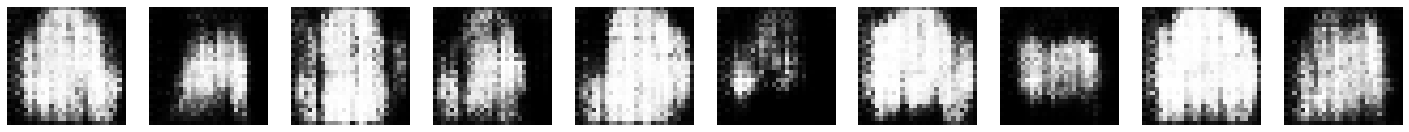

... finished after 30.54 seconds 
Epoch: __ 15
Iteration #100 - Discriminator loss: 1.3865, Generator loss: 0.6855
Iteration #200 - Discriminator loss: 1.3872, Generator loss: 0.6877
Iteration #300 - Discriminator loss: 1.3867, Generator loss: 0.6892
Iteration #400 - Discriminator loss: 1.3869, Generator loss: 0.6898
Iteration #500 - Discriminator loss: 1.3863, Generator loss: 0.6904
Iteration #600 - Discriminator loss: 1.3863, Generator loss: 0.6908
Iteration #700 - Discriminator loss: 1.3866, Generator loss: 0.6906
Iteration #800 - Discriminator loss: 1.3863, Generator loss: 0.6906
Iteration #900 - Discriminator loss: 1.3866, Generator loss: 0.6903


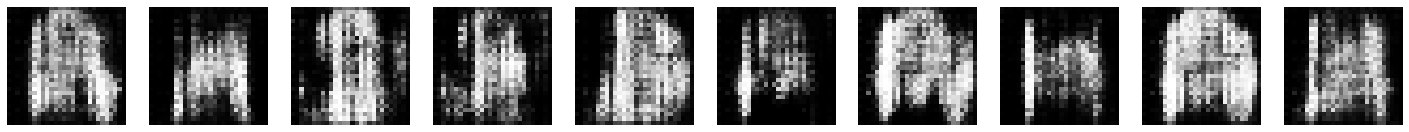

... finished after 30.53 seconds 
Epoch: __ 16
Iteration #100 - Discriminator loss: 1.3867, Generator loss: 0.6894
Iteration #200 - Discriminator loss: 1.3863, Generator loss: 0.6898
Iteration #300 - Discriminator loss: 1.3862, Generator loss: 0.6905
Iteration #400 - Discriminator loss: 1.3864, Generator loss: 0.6906
Iteration #500 - Discriminator loss: 1.3862, Generator loss: 0.6906
Iteration #600 - Discriminator loss: 1.386, Generator loss: 0.6888
Iteration #700 - Discriminator loss: 1.3876, Generator loss: 0.6853
Iteration #800 - Discriminator loss: 1.3867, Generator loss: 0.6896
Iteration #900 - Discriminator loss: 1.3868, Generator loss: 0.6905


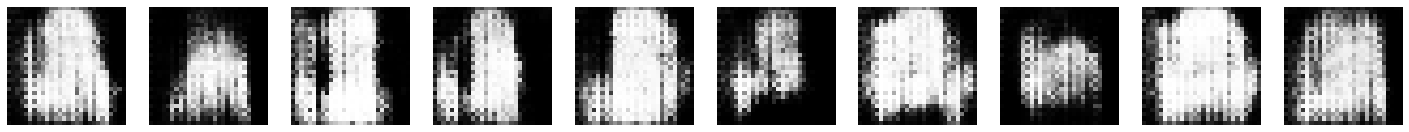

... finished after 30.37 seconds 
Epoch: __ 17
Iteration #100 - Discriminator loss: 1.3866, Generator loss: 0.6916
Iteration #200 - Discriminator loss: 1.3864, Generator loss: 0.6918
Iteration #300 - Discriminator loss: 1.3861, Generator loss: 0.6916
Iteration #400 - Discriminator loss: 1.3863, Generator loss: 0.6912
Iteration #500 - Discriminator loss: 1.3865, Generator loss: 0.6913
Iteration #600 - Discriminator loss: 1.3865, Generator loss: 0.6919
Iteration #700 - Discriminator loss: 1.3863, Generator loss: 0.6921
Iteration #800 - Discriminator loss: 1.3863, Generator loss: 0.6921
Iteration #900 - Discriminator loss: 1.3863, Generator loss: 0.6921


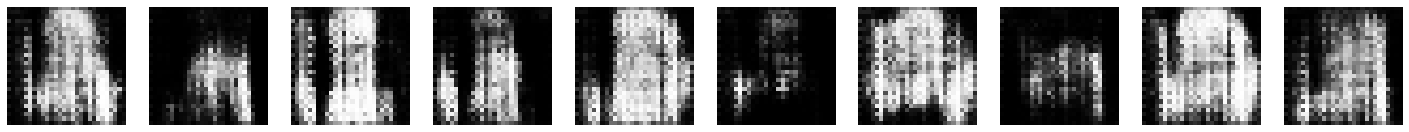

... finished after 30.69 seconds 
Epoch: __ 18
Iteration #100 - Discriminator loss: 1.3862, Generator loss: 0.692
Iteration #200 - Discriminator loss: 1.3863, Generator loss: 0.6917
Iteration #300 - Discriminator loss: 1.3865, Generator loss: 0.6914
Iteration #400 - Discriminator loss: 1.3862, Generator loss: 0.6913
Iteration #500 - Discriminator loss: 1.386, Generator loss: 0.6916
Iteration #600 - Discriminator loss: 1.386, Generator loss: 0.6915
Iteration #700 - Discriminator loss: 1.3862, Generator loss: 0.6908
Iteration #800 - Discriminator loss: 1.3855, Generator loss: 0.6902
Iteration #900 - Discriminator loss: 1.3868, Generator loss: 0.6897


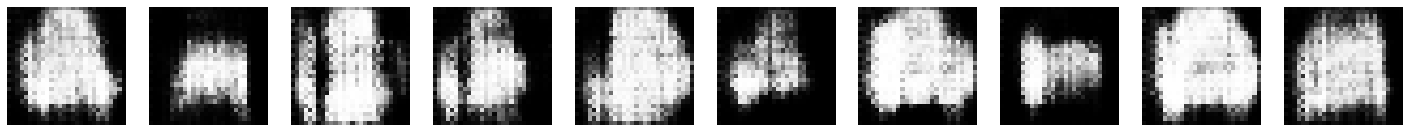

... finished after 30.54 seconds 
Epoch: __ 19
Iteration #100 - Discriminator loss: 1.3866, Generator loss: 0.6914
Iteration #200 - Discriminator loss: 1.3865, Generator loss: 0.6919
Iteration #300 - Discriminator loss: 1.3865, Generator loss: 0.692
Iteration #400 - Discriminator loss: 1.3863, Generator loss: 0.6922
Iteration #500 - Discriminator loss: 1.3864, Generator loss: 0.6923
Iteration #600 - Discriminator loss: 1.3863, Generator loss: 0.6925
Iteration #700 - Discriminator loss: 1.3863, Generator loss: 0.6926
Iteration #800 - Discriminator loss: 1.3863, Generator loss: 0.6926
Iteration #900 - Discriminator loss: 1.3863, Generator loss: 0.6926


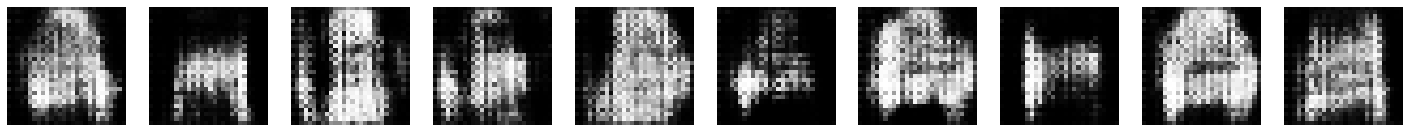

... finished after 30.32 seconds 
Epoch: __ 20
Iteration #100 - Discriminator loss: 1.3863, Generator loss: 0.6926
Iteration #200 - Discriminator loss: 1.3862, Generator loss: 0.6924
Iteration #300 - Discriminator loss: 1.3863, Generator loss: 0.6922
Iteration #400 - Discriminator loss: 1.3865, Generator loss: 0.6922
Iteration #500 - Discriminator loss: 1.3865, Generator loss: 0.6924
Iteration #600 - Discriminator loss: 1.3864, Generator loss: 0.6927
Iteration #700 - Discriminator loss: 1.3864, Generator loss: 0.6928
Iteration #800 - Discriminator loss: 1.3863, Generator loss: 0.6928
Iteration #900 - Discriminator loss: 1.3863, Generator loss: 0.6928


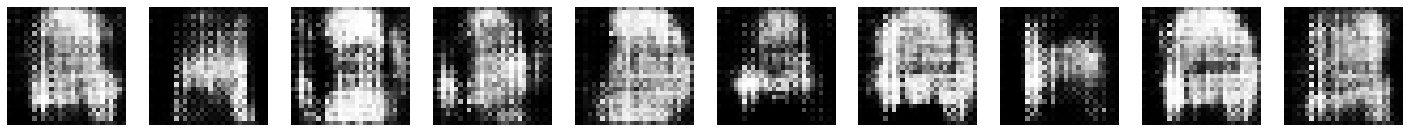

... finished after 30.4 seconds 


In [85]:
train_losses_d, test_losses_d, train_losses_g, test_losses_g, train_losses_g_all, train_losses_d_all = train(
    num_epochs=num_epochs, 
    generator=generator, 
    discriminator=discriminator, 
    g_loss=generator_loss, 
    d_loss=discriminator_loss, 
    optimizer_generator=optimizer_generator, 
    optimizer_discriminator=optimizer_discriminator)

**Evaluation of GAN**

Taking a look at the images produced by the generator, one can see that so far we are only able to create indistinguishable white blobs on black background. The following plot shows how the losses do not really change a lot during the last epochs. Further improvement must be done - in the next section we will see whether WGAN improves our results.

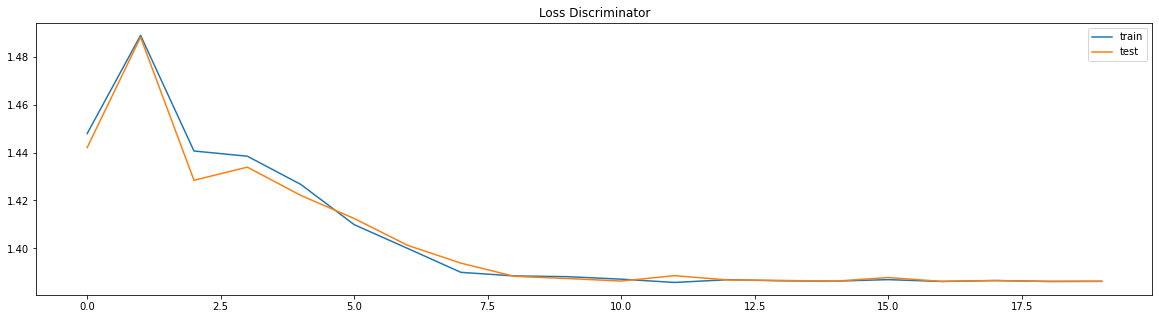

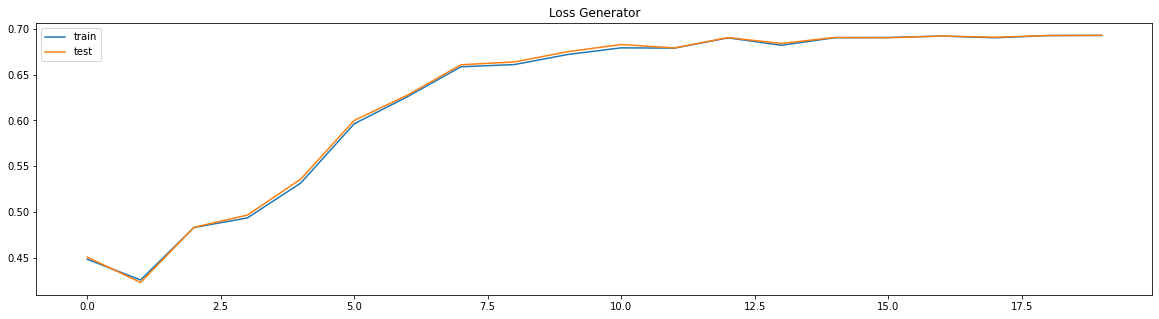

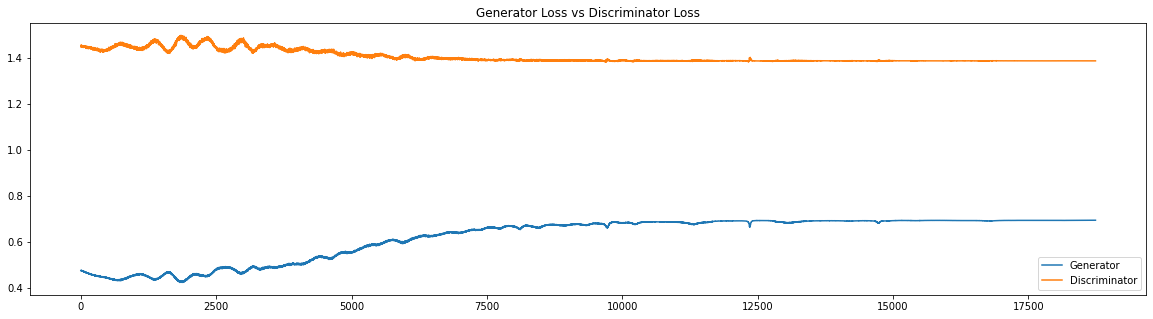

In [88]:
plot(train_losses_d, test_losses_d, train_losses_g, test_losses_g, train_losses_g_all, train_losses_d_all)

**Setup for training  (WGAN)**

For training with WGAN adjustments we chose:
* a learning rate of 0.00005
* Wasserstein loss for discriminator
* optimizer: RMSprop
* weight clipping in the Discriminator (Wasserstein adaption is allowed through the boolean 'wasserstein' when initialising the discriminator -> True will yield the Wasserstein discriminator, False will yield the 'normal' discriminator)

In [91]:
K.clear_session()

# Use wasserstein (True) or not (False)
WASSERSTEIN = True

# Hyperparameters for training
num_epochs = 20
learning_rate = 0.00005
running_average_factor = 0.95

# Initializing discriminator (passing 'true' to initialize the Wasserstein 
# discriminator -> weight clipping) and generator
discriminator = Discriminator(wasserstein=WASSERSTEIN)
generator = Generator()

# Adam optimizer
optimizer_discriminator = tf.keras.optimizers.RMSprop(learning_rate)
optimizer_generator = tf.keras.optimizers.RMSprop(learning_rate)

# Initialize lists for visualization.
train_losses_discriminator, train_losses_generator = [], []
test_losses_discriminator, test_losses_generator = [], []

Epoch: __ 1
Iteration #100 - Discriminator loss: -0.0902, Generator loss: -0.0895
Iteration #200 - Discriminator loss: -0.0543, Generator loss: -0.1245
Iteration #300 - Discriminator loss: -0.0282, Generator loss: -0.0219
Iteration #400 - Discriminator loss: -0.0402, Generator loss: 0.0262
Iteration #500 - Discriminator loss: -0.0143, Generator loss: -0.0562
Iteration #600 - Discriminator loss: -0.0032, Generator loss: -0.0711
Iteration #700 - Discriminator loss: -0.0045, Generator loss: -0.0391
Iteration #800 - Discriminator loss: -0.0063, Generator loss: -0.0682
Iteration #900 - Discriminator loss: -0.0038, Generator loss: -0.0318


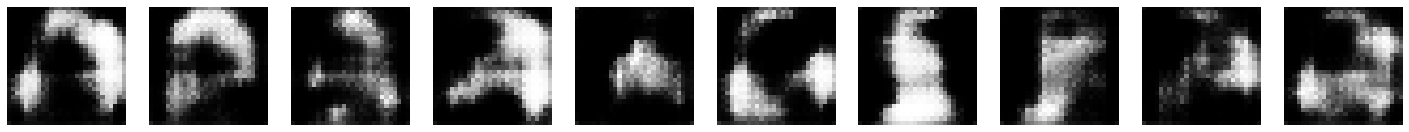

... finished after 34.02 seconds 
Epoch: __ 2
Iteration #100 - Discriminator loss: -0.0051, Generator loss: -0.0075
Iteration #200 - Discriminator loss: -0.0054, Generator loss: -0.0301
Iteration #300 - Discriminator loss: -0.0075, Generator loss: -0.0049
Iteration #400 - Discriminator loss: -0.0048, Generator loss: -0.0072
Iteration #500 - Discriminator loss: -0.0056, Generator loss: -0.0151
Iteration #600 - Discriminator loss: -0.0047, Generator loss: -0.0091
Iteration #700 - Discriminator loss: -0.0098, Generator loss: -0.0121
Iteration #800 - Discriminator loss: -0.0105, Generator loss: -0.0276
Iteration #900 - Discriminator loss: -0.0082, Generator loss: 0.0067


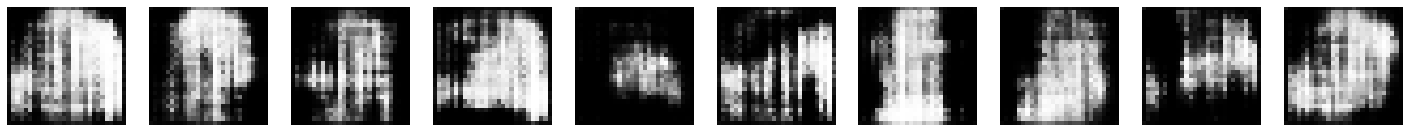

... finished after 33.91 seconds 
Epoch: __ 3
Iteration #100 - Discriminator loss: -0.0064, Generator loss: 0.0097
Iteration #200 - Discriminator loss: -0.0064, Generator loss: 0.012
Iteration #300 - Discriminator loss: -0.0033, Generator loss: -0.0107
Iteration #400 - Discriminator loss: -0.0069, Generator loss: -0.0229
Iteration #500 - Discriminator loss: -0.0099, Generator loss: 0.0116
Iteration #600 - Discriminator loss: -0.009, Generator loss: 0.0031
Iteration #700 - Discriminator loss: -0.0135, Generator loss: 0.0119
Iteration #800 - Discriminator loss: -0.0087, Generator loss: 0.0124
Iteration #900 - Discriminator loss: -0.0096, Generator loss: -0.0621


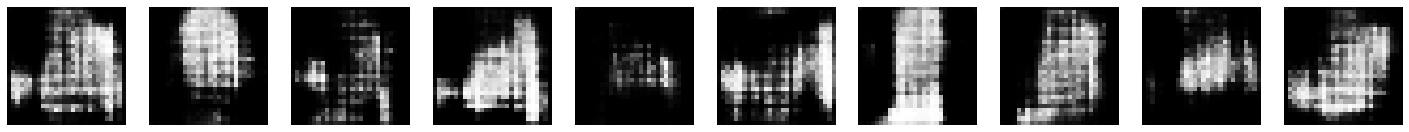

... finished after 33.93 seconds 
Epoch: __ 4
Iteration #100 - Discriminator loss: -0.0107, Generator loss: -0.0233
Iteration #200 - Discriminator loss: -0.0114, Generator loss: -0.0317
Iteration #300 - Discriminator loss: -0.0121, Generator loss: -0.0076
Iteration #400 - Discriminator loss: -0.0131, Generator loss: -0.0088
Iteration #500 - Discriminator loss: -0.0133, Generator loss: 0.0136
Iteration #600 - Discriminator loss: -0.0125, Generator loss: -0.0322
Iteration #700 - Discriminator loss: -0.0302, Generator loss: -0.0735
Iteration #800 - Discriminator loss: -0.0036, Generator loss: 0.026
Iteration #900 - Discriminator loss: -0.0094, Generator loss: -0.0592


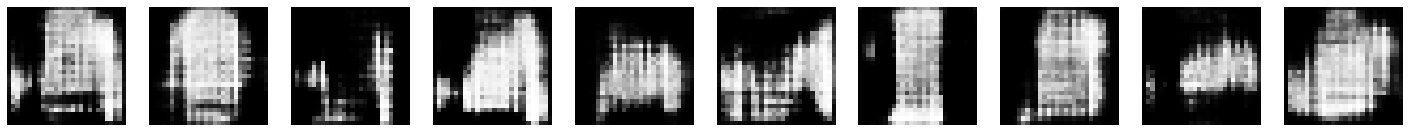

... finished after 33.99 seconds 
Epoch: __ 5
Iteration #100 - Discriminator loss: -0.0193, Generator loss: -0.0419
Iteration #200 - Discriminator loss: -0.0179, Generator loss: 0.0181
Iteration #300 - Discriminator loss: -0.0173, Generator loss: -0.0892
Iteration #400 - Discriminator loss: -0.0161, Generator loss: -0.1181
Iteration #500 - Discriminator loss: -0.0198, Generator loss: 0.0126
Iteration #600 - Discriminator loss: -0.0101, Generator loss: 0.0288
Iteration #700 - Discriminator loss: -0.0156, Generator loss: -0.0734
Iteration #800 - Discriminator loss: -0.0144, Generator loss: -0.0666
Iteration #900 - Discriminator loss: -0.0169, Generator loss: -0.0533


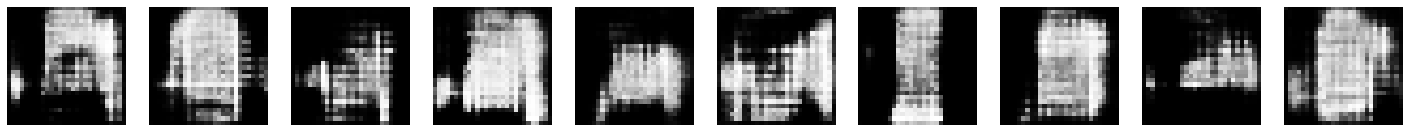

... finished after 34.38 seconds 
Epoch: __ 6
Iteration #100 - Discriminator loss: -0.0165, Generator loss: -0.0119
Iteration #200 - Discriminator loss: -0.0053, Generator loss: -0.0918
Iteration #300 - Discriminator loss: -0.0207, Generator loss: 0.0474
Iteration #400 - Discriminator loss: -0.004, Generator loss: -0.0968
Iteration #500 - Discriminator loss: -0.0066, Generator loss: 0.0182
Iteration #600 - Discriminator loss: -0.0042, Generator loss: 0.0057
Iteration #700 - Discriminator loss: -0.0243, Generator loss: -0.0818
Iteration #800 - Discriminator loss: 0.004, Generator loss: 0.0863
Iteration #900 - Discriminator loss: -0.0151, Generator loss: -0.054


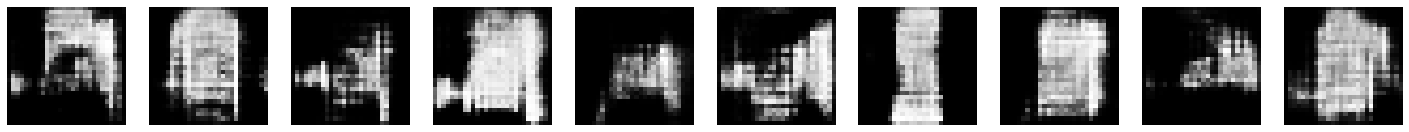

... finished after 34.12 seconds 
Epoch: __ 7
Iteration #100 - Discriminator loss: -0.0172, Generator loss: -0.0266
Iteration #200 - Discriminator loss: -0.0237, Generator loss: -0.044
Iteration #300 - Discriminator loss: -0.0151, Generator loss: -0.0507
Iteration #400 - Discriminator loss: -0.0175, Generator loss: -0.0414
Iteration #500 - Discriminator loss: -0.001, Generator loss: -0.2279
Iteration #600 - Discriminator loss: -0.0279, Generator loss: 0.0604
Iteration #700 - Discriminator loss: -0.023, Generator loss: 0.0496
Iteration #800 - Discriminator loss: -0.0215, Generator loss: -0.0156
Iteration #900 - Discriminator loss: -0.0295, Generator loss: -0.0551


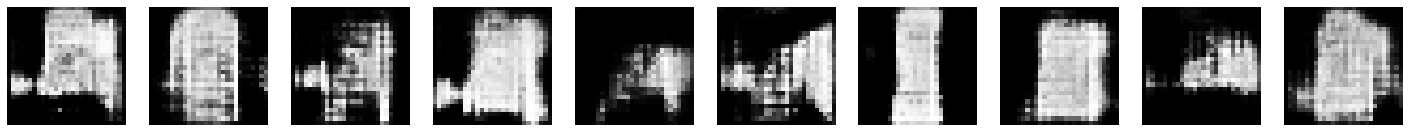

... finished after 34.15 seconds 
Epoch: __ 8
Iteration #100 - Discriminator loss: -0.0191, Generator loss: 0.0123
Iteration #200 - Discriminator loss: -0.0214, Generator loss: -0.0806
Iteration #300 - Discriminator loss: -0.0284, Generator loss: 0.0436
Iteration #400 - Discriminator loss: -0.0244, Generator loss: 0.027
Iteration #500 - Discriminator loss: -0.0381, Generator loss: -0.0301
Iteration #600 - Discriminator loss: -0.0141, Generator loss: 0.0293
Iteration #700 - Discriminator loss: -0.0136, Generator loss: 0.0632
Iteration #800 - Discriminator loss: -0.0221, Generator loss: -0.0246
Iteration #900 - Discriminator loss: -0.0192, Generator loss: -0.0266


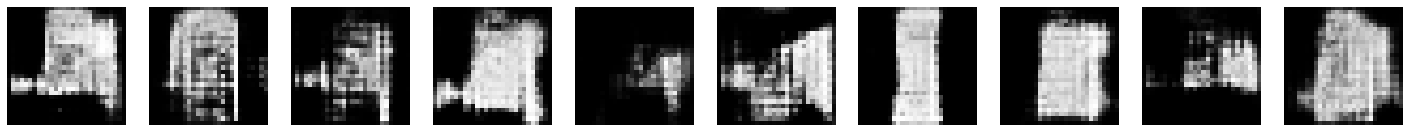

... finished after 33.89 seconds 
Epoch: __ 9
Iteration #100 - Discriminator loss: -0.0055, Generator loss: 0.0285
Iteration #200 - Discriminator loss: -0.0153, Generator loss: -0.063
Iteration #300 - Discriminator loss: -0.012, Generator loss: 0.0878
Iteration #400 - Discriminator loss: -0.0286, Generator loss: -0.0578
Iteration #500 - Discriminator loss: -0.0256, Generator loss: -0.1076
Iteration #600 - Discriminator loss: -0.0225, Generator loss: -0.0066
Iteration #700 - Discriminator loss: -0.024, Generator loss: -0.0145
Iteration #800 - Discriminator loss: -0.0165, Generator loss: -0.1113
Iteration #900 - Discriminator loss: -0.0125, Generator loss: -0.0945


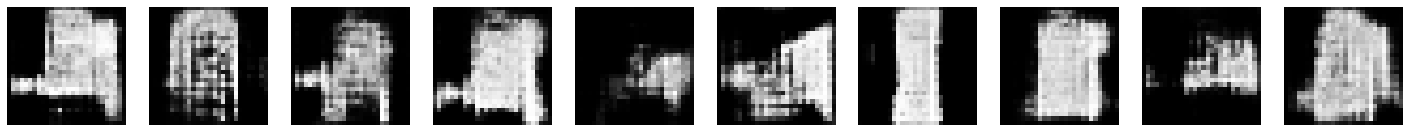

... finished after 33.85 seconds 
Epoch: __ 10
Iteration #100 - Discriminator loss: -0.0428, Generator loss: -0.233
Iteration #200 - Discriminator loss: -0.0387, Generator loss: 0.0997
Iteration #300 - Discriminator loss: -0.0576, Generator loss: 0.1285
Iteration #400 - Discriminator loss: -0.0215, Generator loss: -0.0452
Iteration #500 - Discriminator loss: -0.0262, Generator loss: -0.0728
Iteration #600 - Discriminator loss: -0.0266, Generator loss: -0.239
Iteration #700 - Discriminator loss: -0.0149, Generator loss: -0.0316
Iteration #800 - Discriminator loss: -0.0169, Generator loss: -0.0113
Iteration #900 - Discriminator loss: -0.0358, Generator loss: -0.1364


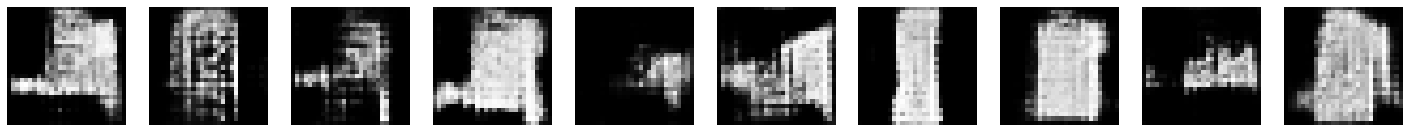

... finished after 34.05 seconds 
Epoch: __ 11
Iteration #100 - Discriminator loss: -0.0332, Generator loss: -0.193
Iteration #200 - Discriminator loss: 0.0039, Generator loss: -0.1905
Iteration #300 - Discriminator loss: -0.0038, Generator loss: 0.1167
Iteration #400 - Discriminator loss: -0.0242, Generator loss: -0.3097
Iteration #500 - Discriminator loss: -0.0134, Generator loss: -0.0084
Iteration #600 - Discriminator loss: -0.022, Generator loss: 0.1896
Iteration #700 - Discriminator loss: -0.0229, Generator loss: -0.231
Iteration #800 - Discriminator loss: -0.0126, Generator loss: -0.1892
Iteration #900 - Discriminator loss: -0.0206, Generator loss: -0.0074


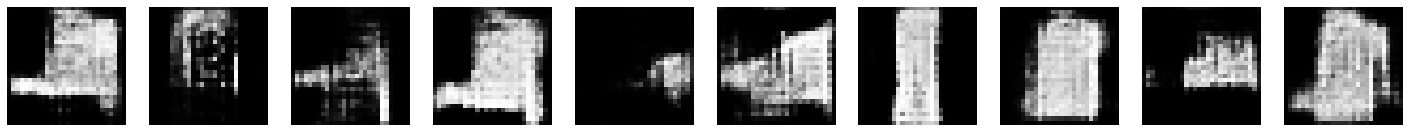

... finished after 33.94 seconds 
Epoch: __ 12
Iteration #100 - Discriminator loss: -0.0073, Generator loss: -0.1339
Iteration #200 - Discriminator loss: -0.0061, Generator loss: -0.1067
Iteration #300 - Discriminator loss: -0.0148, Generator loss: 0.0466
Iteration #400 - Discriminator loss: -0.0198, Generator loss: -0.0141
Iteration #500 - Discriminator loss: -0.0256, Generator loss: -0.0663
Iteration #600 - Discriminator loss: -0.0142, Generator loss: 0.0385
Iteration #700 - Discriminator loss: -0.0316, Generator loss: -0.0311
Iteration #800 - Discriminator loss: -0.013, Generator loss: -0.1685
Iteration #900 - Discriminator loss: -0.0233, Generator loss: -0.025


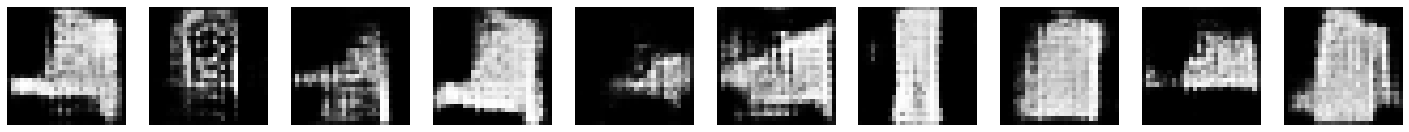

... finished after 33.87 seconds 
Epoch: __ 13
Iteration #100 - Discriminator loss: -0.019, Generator loss: -0.0621
Iteration #200 - Discriminator loss: -0.0388, Generator loss: 0.124
Iteration #300 - Discriminator loss: -0.0217, Generator loss: -0.0381
Iteration #400 - Discriminator loss: -0.0206, Generator loss: 0.0184
Iteration #500 - Discriminator loss: -0.0173, Generator loss: 0.1035
Iteration #600 - Discriminator loss: -0.0224, Generator loss: -0.0698
Iteration #700 - Discriminator loss: -0.0417, Generator loss: -0.1067
Iteration #800 - Discriminator loss: -0.0098, Generator loss: -0.1316
Iteration #900 - Discriminator loss: -0.0248, Generator loss: 0.0582


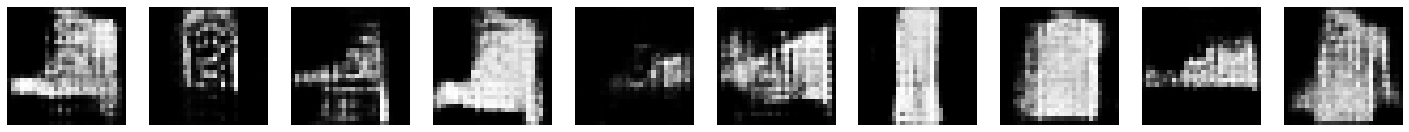

... finished after 33.91 seconds 
Epoch: __ 14
Iteration #100 - Discriminator loss: 0.0276, Generator loss: 0.1825
Iteration #200 - Discriminator loss: -0.0017, Generator loss: 0.0453
Iteration #300 - Discriminator loss: -0.013, Generator loss: -0.0409
Iteration #400 - Discriminator loss: 0.0134, Generator loss: -0.3461
Iteration #500 - Discriminator loss: -0.01, Generator loss: -0.0472
Iteration #600 - Discriminator loss: 0.0277, Generator loss: 0.1599
Iteration #700 - Discriminator loss: 0.0243, Generator loss: 0.1262
Iteration #800 - Discriminator loss: -0.0306, Generator loss: -0.1398
Iteration #900 - Discriminator loss: 0.0384, Generator loss: -0.4228


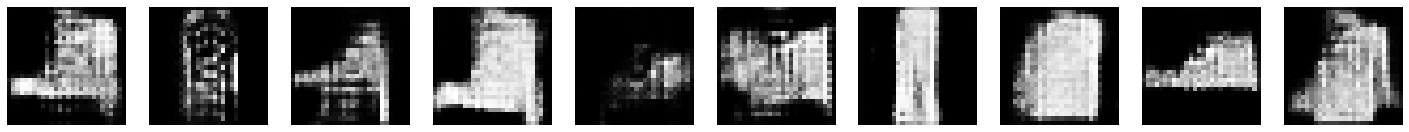

... finished after 34.27 seconds 
Epoch: __ 15
Iteration #100 - Discriminator loss: -0.022, Generator loss: -0.126
Iteration #200 - Discriminator loss: -0.0326, Generator loss: -0.1923
Iteration #300 - Discriminator loss: -0.0009, Generator loss: -0.3932
Iteration #400 - Discriminator loss: -0.0153, Generator loss: 0.2264
Iteration #500 - Discriminator loss: -0.0131, Generator loss: -0.2254
Iteration #600 - Discriminator loss: -0.003, Generator loss: -0.0117
Iteration #700 - Discriminator loss: 0.0044, Generator loss: -0.1651
Iteration #800 - Discriminator loss: -0.0115, Generator loss: -0.1712
Iteration #900 - Discriminator loss: -0.0122, Generator loss: -0.0925


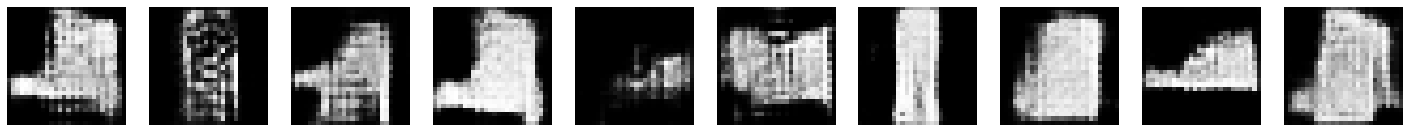

... finished after 33.83 seconds 
Epoch: __ 16
Iteration #100 - Discriminator loss: -0.0046, Generator loss: 0.0439
Iteration #200 - Discriminator loss: -0.0275, Generator loss: 0.0782
Iteration #300 - Discriminator loss: -0.0286, Generator loss: -0.1413
Iteration #400 - Discriminator loss: -0.0141, Generator loss: -0.0642
Iteration #500 - Discriminator loss: -0.0108, Generator loss: -0.3895
Iteration #600 - Discriminator loss: -0.0231, Generator loss: 0.0657
Iteration #700 - Discriminator loss: 0.0141, Generator loss: 0.0389
Iteration #800 - Discriminator loss: -0.0557, Generator loss: -0.2665
Iteration #900 - Discriminator loss: -0.0583, Generator loss: 0.296


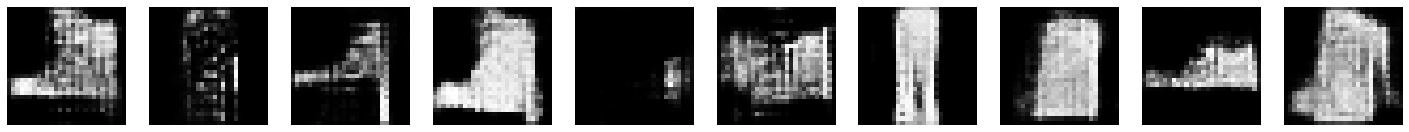

... finished after 34.1 seconds 
Epoch: __ 17
Iteration #100 - Discriminator loss: -0.0076, Generator loss: -0.1126
Iteration #200 - Discriminator loss: -0.0144, Generator loss: -0.0378
Iteration #300 - Discriminator loss: -0.0296, Generator loss: -0.0536
Iteration #400 - Discriminator loss: -0.0155, Generator loss: -0.2854
Iteration #500 - Discriminator loss: -0.0167, Generator loss: -0.0887
Iteration #600 - Discriminator loss: -0.0327, Generator loss: -0.1563
Iteration #700 - Discriminator loss: -0.0284, Generator loss: -0.2079
Iteration #800 - Discriminator loss: -0.0453, Generator loss: -0.2969
Iteration #900 - Discriminator loss: -0.0055, Generator loss: -0.2077


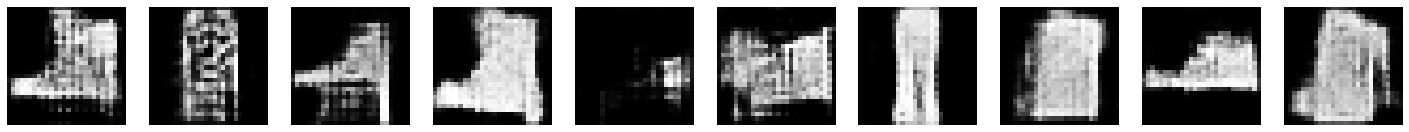

... finished after 33.91 seconds 
Epoch: __ 18
Iteration #100 - Discriminator loss: -0.0243, Generator loss: -0.0725
Iteration #200 - Discriminator loss: -0.0041, Generator loss: -0.0211
Iteration #300 - Discriminator loss: -0.016, Generator loss: -0.3581
Iteration #400 - Discriminator loss: -0.0108, Generator loss: -0.2248
Iteration #500 - Discriminator loss: -0.028, Generator loss: -0.1363
Iteration #600 - Discriminator loss: -0.0221, Generator loss: -0.1313
Iteration #700 - Discriminator loss: 0.0308, Generator loss: -0.3801
Iteration #800 - Discriminator loss: -0.0146, Generator loss: 0.0216
Iteration #900 - Discriminator loss: -0.0065, Generator loss: -0.164


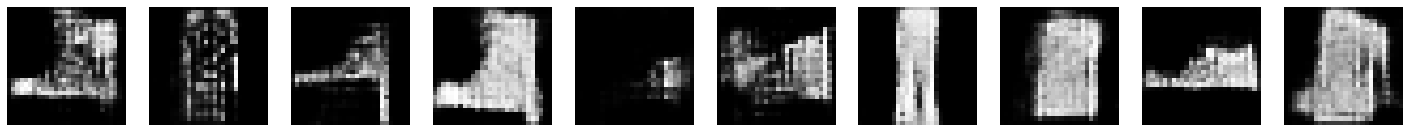

... finished after 33.81 seconds 
Epoch: __ 19
Iteration #100 - Discriminator loss: -0.0, Generator loss: -0.3007
Iteration #200 - Discriminator loss: -0.0317, Generator loss: -0.1483
Iteration #300 - Discriminator loss: -0.0279, Generator loss: -0.298
Iteration #400 - Discriminator loss: 0.004, Generator loss: -0.0073
Iteration #500 - Discriminator loss: -0.0071, Generator loss: -0.0471
Iteration #600 - Discriminator loss: -0.0155, Generator loss: -0.0846
Iteration #700 - Discriminator loss: -0.0082, Generator loss: 0.1445
Iteration #800 - Discriminator loss: -0.0306, Generator loss: 0.1492
Iteration #900 - Discriminator loss: -0.0543, Generator loss: 0.1341


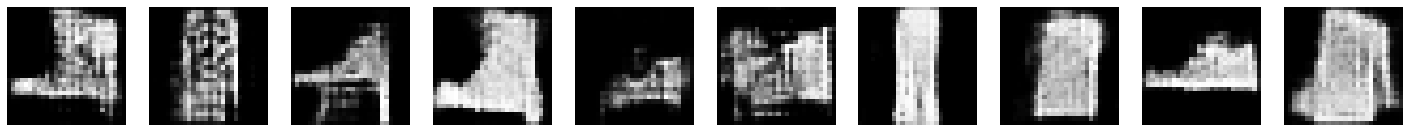

... finished after 33.93 seconds 
Epoch: __ 20
Iteration #100 - Discriminator loss: -0.0086, Generator loss: 0.0316
Iteration #200 - Discriminator loss: -0.0109, Generator loss: 0.027
Iteration #300 - Discriminator loss: 0.037, Generator loss: -0.3749
Iteration #400 - Discriminator loss: -0.0364, Generator loss: -0.2721
Iteration #500 - Discriminator loss: -0.0968, Generator loss: 0.3854
Iteration #600 - Discriminator loss: 0.0452, Generator loss: -0.0097
Iteration #700 - Discriminator loss: 0.0253, Generator loss: 0.1955
Iteration #800 - Discriminator loss: -0.0338, Generator loss: -0.0471
Iteration #900 - Discriminator loss: 0.0031, Generator loss: -0.0698


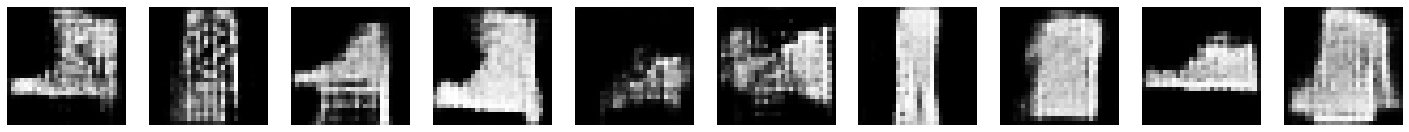

... finished after 34.0 seconds 


In [92]:
w_train_losses_d, w_test_losses_d, w_train_losses_g, w_test_losses_g, w_train_losses_g_all, w_train_losses_d_all = train(
    num_epochs=num_epochs, 
    generator=generator, 
    discriminator=discriminator, 
    g_loss=w_generator_loss, # Wasserstein loss adaption
    d_loss=w_discriminator_loss, # Wasserstein loss adaption
    optimizer_generator=optimizer_generator, 
    optimizer_discriminator=optimizer_discriminator)

**Evaluation of WGAN**

Using WGAN adjustments, we are able to construct images that look something like clothing. Some generated images are more distinguishable, others less  - but overall, the Wasserstein adjustments allowed for better results compared to the 'normal' GAN.

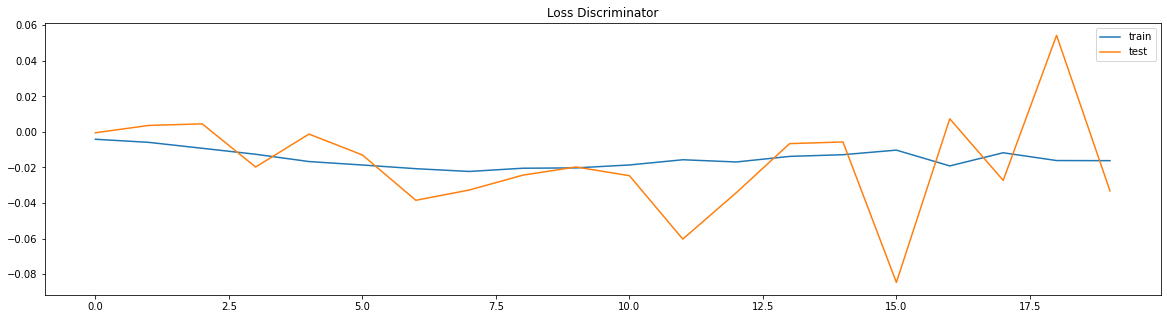

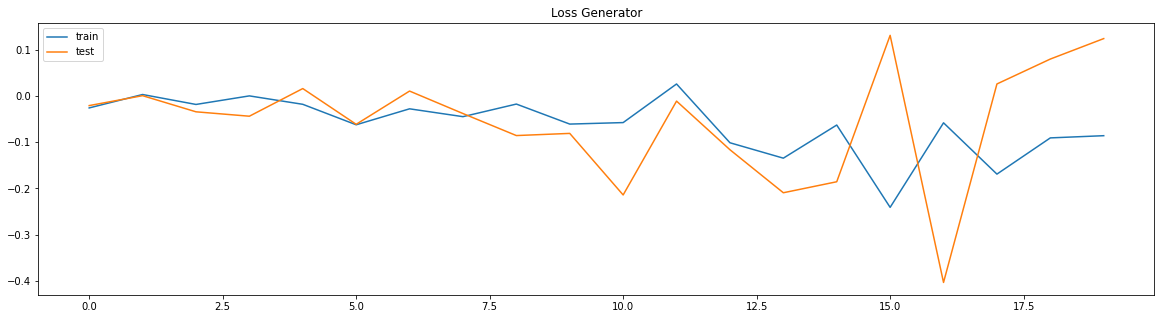

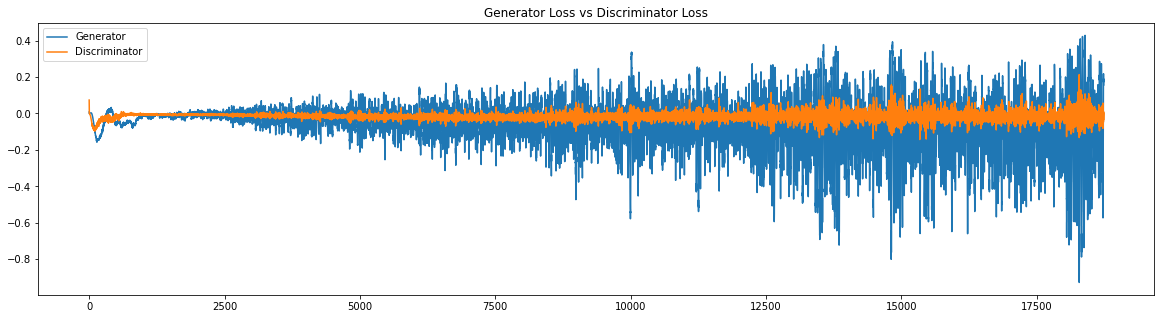

In [93]:
plot(w_train_losses_d, w_test_losses_d, w_train_losses_g, w_test_losses_g, w_train_losses_g_all, w_train_losses_d_all)